In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)

In [25]:
filename = 'data/figures.png'

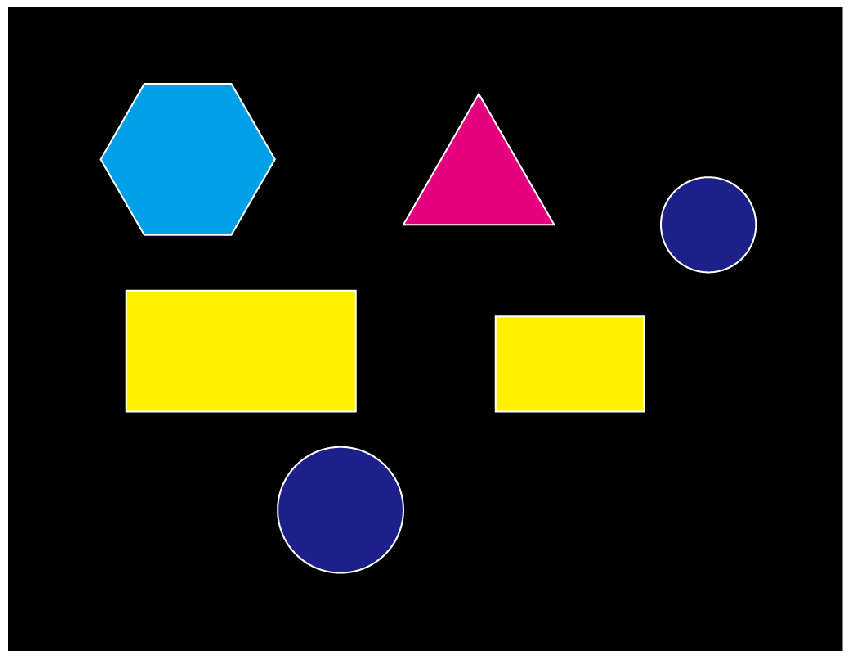

In [26]:
image = cv2.imread(filename, cv2.IMREAD_COLOR)
if image is None:
    raise Exception('Failed to load image: ' + filename)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

## エッジの検出

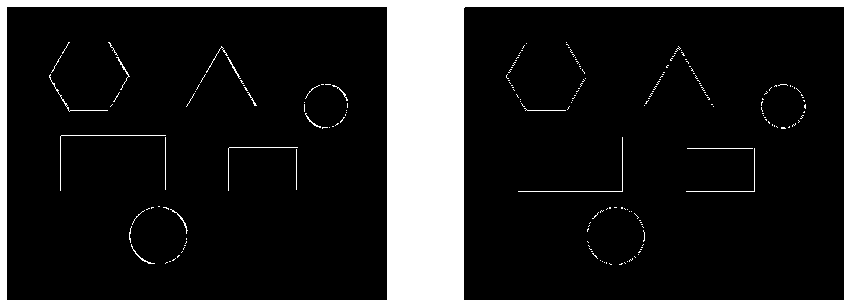

In [27]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dx = cv2.Sobel(gray, cv2.CV_8U, 1, 0)
dy = cv2.Sobel(gray, cv2.CV_8U, 0, 1)
sobel = (np.sqrt(dx * dx + dy * dy) * 128.0).astype('uint8')
_, sobel = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite('sobel.jpg', sobel)

edge = cv2.Canny(gray, 100, 200)
cv2.imwrite('canny.jpg', edge)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sobel, cmap='gray')
ax.axis('off')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(edge, cmap='gray')
ax.axis('off')
plt.show()

## エッジの強調

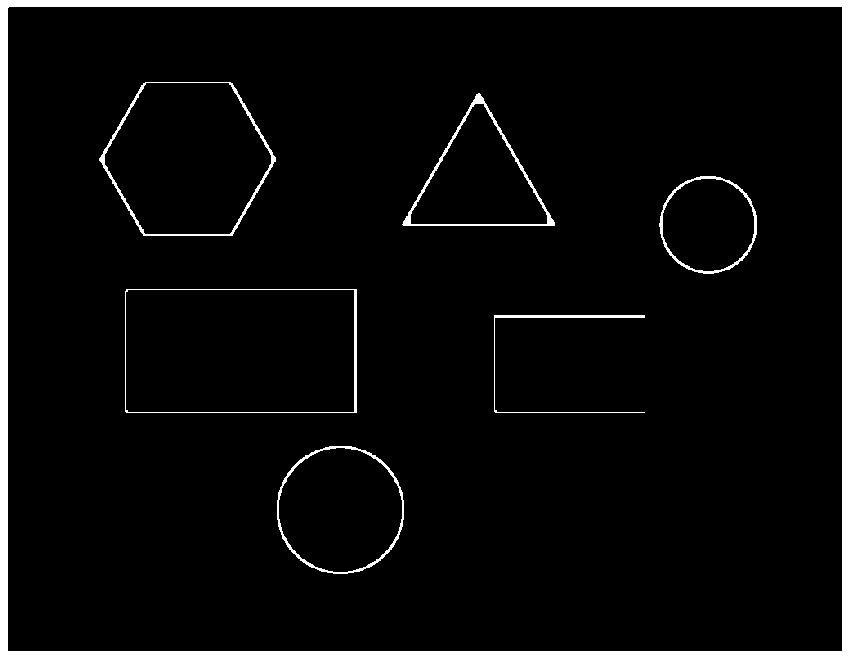

In [28]:
height, width = edge.shape
ksize = int(max(height, width) * 0.01)
ksize = ksize // 2 * 2 + 1
#edge = cv2.dilate(edge, np.ones((ksize, ksize), dtype='uint8'))
#edge = cv2.erode(edge, np.ones((ksize, ksize), dtype='uint8'))
edge = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, np.ones((ksize, ksize), dtype='uint8'))
plt.imshow(edge, cmap='gray')
plt.axis('off')
plt.show()

## 輪郭線の抽出

In [37]:
_, contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('{:d} contours detected!'.format(len(contours)))

7 contours detected!


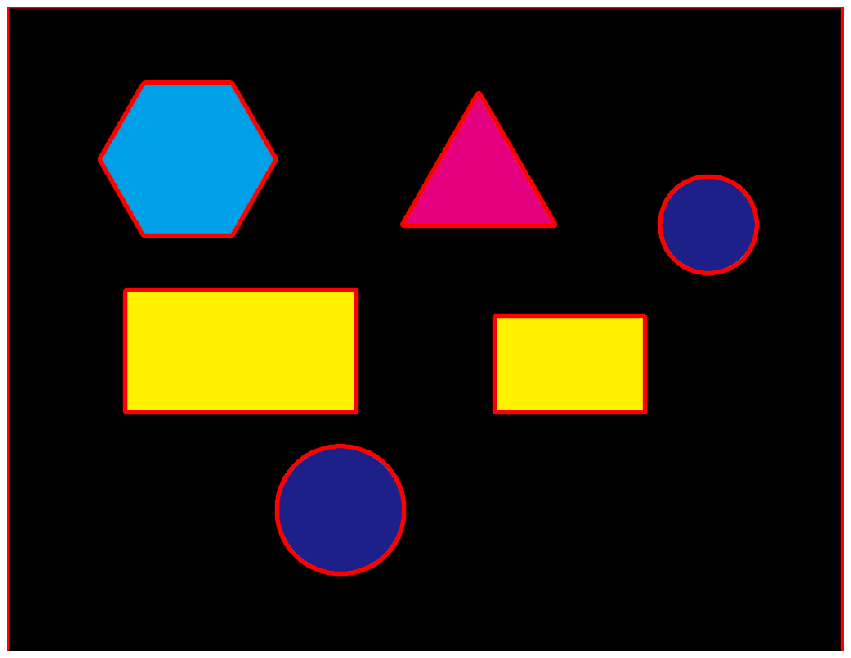

In [30]:
result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
cv2.imwrite('draw_contours.jpg', result[:, :, ::-1])
plt.imshow(result)
plt.axis('off')
plt.show()

## 輪郭線の分類

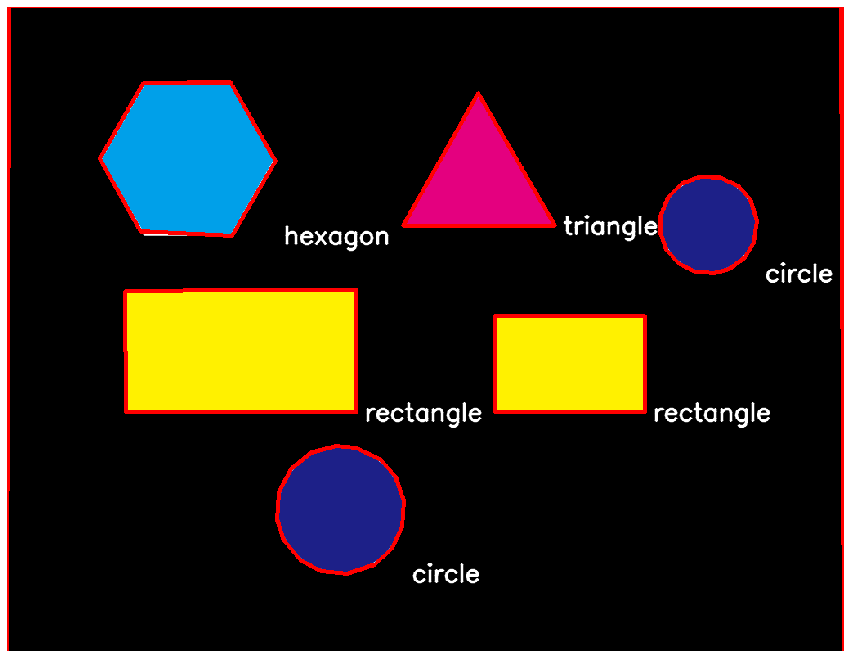

In [57]:
result = image.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

for cnt in contours:
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, arclen * 1.0e-2, True)
    cv2.drawContours(result, [approx], -1, (255, 0, 0), 3)

    n_gon = len(approx)
    text = 'unknown'
    if n_gon > 10:
        text = 'circle'
    elif n_gon == 6:
        text = 'hexagon'
    elif n_gon == 5:
        text = 'pentagon'
    elif n_gon == 4:
        text = 'rectangle'
    elif n_gon == 3:
        text = 'triangle'
    
    position = np.asarray(approx).reshape((-1, 2)).max(axis=0).astype('int32')
    px, py = position
    cv2.putText(result, text, (px + 10, py + 10), font, 1.0, (255, 255, 255), 2, cv2.LINE_AA)

cv2.imwrite('detection.jpg', result[:, :, ::-1])
plt.imshow(result)
plt.axis('off')
plt.show()